In [114]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# Load from env
load_dotenv()

model = init_chat_model("gpt-4o-mini")

In [115]:
from pathlib import Path
import sys
# append dev directory to sys.path
sys.path.insert(0, str(Path.cwd().parent / "agent"))

In [116]:
# Import the data exploration agent
from data_exploration_subagent import build_agent as build_data_exploration_agent
from langchain.tools import tool

# Build the data exploration agent
data_exploration_agent = build_data_exploration_agent()

# Wrap data_exploration_agent as a tool
@tool("database_exploration_agent", description="Use this agent to explore and query the art database. Provide a natural language question about the art data.")
def call_data_exploration_agent(query: str) -> str:
    """
    Call the database exploration agent to answer questions about the art database.
    
    Args:
        query: A natural language question about the art data
        
    Returns:
        The response from the data exploration agent
    """
    result = data_exploration_agent.invoke(
        {"messages": [{"role": "user", "content": query}]}
    )
    return result["messages"][-1].content

In [117]:
from image_qna_tool import build_image_qna_tool
image_qna_tool = build_image_qna_tool()

# Replanning tool - will be populated later in the notebook
# This is declared here as a placeholder
revise_plan_tool = None


In [118]:
from langchain.tools import tool

# Replanning tool - allows LLM to revise the plan when current approach isn't working
@tool("revise_plan", description="Use this tool to revise the current plan when the current approach is not yielding expected results or when you encounter errors.")
def revise_plan_tool(reason: str) -> str:
    """
    Revise the current plan based on feedback about why it's not working.
    This tool will trigger a plan revision with the given reason.
    
    Args:
        reason: Detailed reason explaining why the current plan needs to be revised
        
    Returns:
        Confirmation that the plan revision has been triggered
    """
    # The actual replanning will be handled in tool_node
    # This tool just signals the intent to revise
    return f"Plan revision triggered. Reason: {reason}. The plan will be revised in the next execution."

tools = [
    image_qna_tool,
    call_data_exploration_agent,
    revise_plan_tool,
]

tools_by_name = {tool.name: tool for tool in tools}


In [119]:
from typing import Annotated, Any, Dict
from langgraph.graph import MessagesState

# Main agent state with error tracking and replanning support
class MainAgentState(MessagesState):
    """Main agent state with error handling and replanning support."""
    base_plan: list[str] = []
    current_step: int = 0
    tool_results: dict[str, Any] = {}   # store results or errors keyed by tool_call_id
    feedback: str = ""                  # for replanning
    replan_count: int = 0               # counter to prevent infinite replanning
    max_replans: int = 3                # maximum number of replans allowed
    step_history: dict[int, str] = {}   # track which steps have been executed

In [120]:
# Helper functions
def format_tools_for_prompt(tools):
    """Format tool descriptions for the prompt."""
    lines = []
    for i, tool in enumerate(tools, start=1):
        lines.append(f"{i}. {tool.name}: {tool.description}")
    return "\n".join(lines)


import re

def parse_plan(plan_text: str) -> list[str]:
    """
    Converts a numbered plan string into a list of steps.
    
    Args:
        plan_text: A string with numbered steps
        
    Returns:
        A list of step descriptions without numbers
    """
    # Split on line breaks and remove empty lines
    lines = [line.strip() for line in plan_text.split("\n") if line.strip()]
    
    steps = []
    for line in lines:
        # Remove the number + dot prefix (e.g., "1. ", "2. ")
        step = re.sub(r"^\d+\.\s*", "", line)
        steps.append(step)
    
    return steps

In [121]:
def plan_and_list_tasks(state: MainAgentState):
    """
    Plan and list tasks. Supports both initial planning and replanning after failures.
    
    Args:
        state: The current agent state
        
    Returns:
        Updated state with new base_plan
    """
    planning_system_prompt = """
    You are an efficient task planner. Your job is to only plan and list tasks or subtasks in the most efficient and resourceful way.
    You are given a user query/task and a list of tools.
    
    list the tasks in the following format:
    1. task 1
    2. task 2
    3. task 3
    ...

    plan and list the tasks in a way that each task can be solved by one of these tools.

    tools:
    1. image_qna_tool: This tool equipped with a visual question answering model that can answer questions related to the images in the database.
    2. database_exploration_agent: This tool can answer questions related to the database but limited to the scope of the schema.

    tools_description:
    {tools}    
    """

    replanning_system_prompt = """
    You are an efficient task planner. Your job is to replan tasks based on feedback from failures.
    
    Previous plan had issues:
    {feedback}

    The original step that failed was: {failed_step}
    
    Please generate a revised plan that avoids this issue or approaches the problem differently.
    Current plan before revision:
    {base_plan}

    tools_description:
    {tools}
    
    Return the plan in the same numbered format (1. step1, 2. step2, etc.)
    """

    # Check if this is a replan due to feedback
    if state.get("base_plan") and state.get("feedback"):
        # Get the failed step for context
        failed_step = state["base_plan"][state["current_step"] - 1] if state["current_step"] > 0 else "Unknown"
        
        print(f"Replanning due to feedback: {state['feedback']}")
        print(f"Failed step was: {failed_step}")
        
        response = model.invoke(
            [
                {"role": "system", "content": replanning_system_prompt.format(
                    tools=format_tools_for_prompt(tools),
                    feedback=state.get("feedback", ""),
                    failed_step=failed_step,
                    base_plan="\n".join(state["base_plan"])
                )},
                {"role": "user", "content": state["messages"][-1].content},
            ]
        )
        
        # Reset current step and feedback after replanning
        state_update = {
            "base_plan": parse_plan(response.content),
            "current_step": 0,
            "feedback": "",
            "replan_count": state.get("replan_count", 0) + 1
        }
        print(f"Replan count: {state_update['replan_count']}/{state['max_replans']}")
    else:
        # First time planning
        response = model.invoke(
            [
                {"role": "system", "content": planning_system_prompt.format(
                    tools=format_tools_for_prompt(tools)
                )},
                {"role": "user", "content": state["messages"][-1].content},
            ]
        )
        
        state_update = {
            "base_plan": parse_plan(response.content),
            "current_step": 0,
            "replan_count": 0
        }
    
    return state_update

In [ ]:
from typing import Literal
from langgraph.graph import END
from langchain_core.messages import ToolMessage

# Main agent system prompt
main_agent_system_prompt = """
You are a helpful assistant designed to solve tasks/questions about the art database.
You have access to a specialized data exploration agent that can query the art database.
You also have access to a tool that can answer questions related to the images in the database.

Your limitation in data exploration agent is that it can only query the database and tasks that demand context outside the database schema are beyond its scope.

When users ask questions about the art database, use the data_exploration_agent tool to find the answers, if the schema and context relates.
When users ask questions regarding the visuals in the images, use the image_qna_tool to solve the tasks.

You can ask the agent multi-step questions and use the results to provide comprehensive responses.
"""


def process_query(state: MainAgentState):
    """
    Process user query with the main agent - execute the current plan step.
    
    Args:
        state: The current agent state
        
    Returns:
        Updated state with tool call message appended to messages
    """
    
    # Safety check: do we have any steps left?
    if state["current_step"] >= len(state["base_plan"]):
        print(f"All steps completed. Current step: {state['current_step']}, Total steps: {len(state['base_plan'])}")
        return {"messages": state["messages"]}  # return current messages unchanged

    # Get the current plan step
    current_step_text = state["base_plan"][state["current_step"]]
    
    print(f"\nProcessing step {state['current_step'] + 1}/{len(state['base_plan'])}: {current_step_text}")

    # System + user messages
    system_message = {"role": "system", "content": main_agent_system_prompt}
    plan_message = {"role": "user", "content": f"Execute the following step: {current_step_text}"}

    # Bind tools the agent can use
    llm_with_tools = model.bind_tools([image_qna_tool, call_data_exploration_agent])

    # Include previous messages for context
    response = llm_with_tools.invoke([system_message] + state["messages"] + [plan_message])

    # Track the step in history
    new_step_history = state["step_history"].copy() if state.get("step_history") else {}
    new_step_history[state["current_step"]] = current_step_text
    
    # Increment the current_step after producing the tool call
    new_current_step = state["current_step"] + 1
    
    # Append response to messages (not replace)
    new_messages = state["messages"] + [response]

    return {
        "messages": new_messages,
        "current_step": new_current_step,
        "step_history": new_step_history
    }


In [123]:
def tool_node(state: MainAgentState):
    """
    Execute tool calls with error handling and proper state management.
    Handles special case of revise_plan tool which modifies the plan.
    
    Args:
        state: The current agent state
        
    Returns:
        Updated state with tool results appended and plan possibly revised
    """
    result = []
    plan_revision_triggered = False
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_call_name = tool_call["name"]
        tool_call_id = tool_call["id"]
        
        # Handle special case: revise_plan tool
        if tool_call_name == "revise_plan":
            plan_revision_triggered = True
            reason = tool_call["args"].get("reason", "Unknown reason")
            print(f"\nPlan revision requested: {reason}")
            
            # Execute the replanning logic
            # Get the failed step for context
            failed_step = state["base_plan"][state["current_step"] - 1] if state["current_step"] > 0 else "Unknown"
            
            replanning_system_prompt = """
            You are an efficient task planner. Your job is to replan tasks based on feedback from failures.
            
            Previous plan had issues:
            {feedback}

            The original step that failed was: {failed_step}
            
            Please generate a revised plan that avoids this issue or approaches the problem differently.
            Current plan before revision:
            {base_plan}

            tools_description:
            {tools}
            
            Return the plan in the same numbered format (1. step1, 2. step2, etc.)
            """
            
            response = model.invoke(
                [
                    {"role": "system", "content": replanning_system_prompt.format(
                        tools=format_tools_for_prompt(tools),
                        feedback=reason,
                        failed_step=failed_step,
                        base_plan="\n".join(state["base_plan"])
                    )},
                    {"role": "user", "content": state["messages"][0].content if state["messages"] else ""},
                ]
            )
            
            # Update state with new plan
            revised_plan = parse_plan(response.content)
            observation = f"Plan has been revised. New plan has {len(revised_plan)} steps."
            print(f"New plan generated with {len(revised_plan)} steps")
            
            # Store the revised plan info for state update
            state["base_plan"] = revised_plan
            state["current_step"] = 0
            state["replan_count"] = state.get("replan_count", 0) + 1
            print(f"Replan count: {state['replan_count']}/{state['max_replans']}")
            
        else:
            # Regular tool execution
            tool = tools_by_name[tool_call_name]
            
            try:
                print(f"Executing tool: {tool_call_name}")
                observation = tool.invoke(tool_call["args"])
                print(f"Tool {tool_call_name} succeeded")
            except Exception as e:
                # Capture error
                observation = f"ERROR: {str(e)}"
                print(f"Tool {tool_call_name} failed: {observation}")
            
            # Save observation (or error) in tool_results
            new_tool_results = state['tool_results'].copy() if state.get('tool_results') else {}
            new_tool_results[tool_call_id] = observation
            state["tool_results"] = new_tool_results
        
        # Create tool message with result
        msg = ToolMessage(content=observation, tool_call_id=tool_call_id)
        result.append(msg)
    
    # Append tool messages to existing messages
    new_messages = state["messages"] + result
    
    # Prepare return state
    return_state = {
        "messages": new_messages,
        "tool_results": state.get("tool_results", {}),
        "base_plan": state.get("base_plan", []),
        "current_step": state.get("current_step", 0),
        "replan_count": state.get("replan_count", 0),
    }
    
    return return_state


In [124]:
# This function is no longer used since replanning is now a tool
# Keeping it for reference in case you want to use LLM analysis for other purposes

# def should_replan_based_on_results(state: MainAgentState) -> bool:
#     """
#     Use the LLM to analyze tool_results and determine if replanning is needed.
#     NOTE: This is deprecated. Replanning is now handled via the revise_plan tool.
#     """
#     pass


In [125]:
def should_continue(state: MainAgentState) -> Literal[END, "tool_execution"]:
    """
    Determine the next step: continue with tool execution or end.
    Replanning is now handled as a tool call, so we only need to decide
    between tool_execution and END.
    
    Args:
        state: The current agent state
        
    Returns:
        "tool_execution" to execute tools, or END to finish
    """
    # Check if we've exceeded max replans
    if state.get("replan_count", 0) >= state.get("max_replans", 3):
        print(f"Max replans ({state['max_replans']}) reached. Ending execution.")
        return END
    
    # Check if the last message has tool calls to execute
    messages = state.get("messages", [])
    if messages:
        last_message = messages[-1]
        # Check for tool_calls in the last message
        if hasattr(last_message, 'tool_calls'):
            tool_calls = last_message.tool_calls
            # Only continue if there are actual tool calls
            if tool_calls and len(tool_calls) > 0:
                print(f"Found {len(tool_calls)} tool call(s) to execute")
                return "tool_execution"
    
    # No tool calls, we're done
    print("No more tool calls. Execution complete.")
    return END


In [126]:
from langgraph.graph import START, StateGraph

# Build the main agent graph
def build_main_agent():
    """
    Build the main agent graph with deterministic flow:
    plan_and_list_tasks -> process_query -> tool_execution -> process_query (loop)
    
    Replanning is now handled as a tool (revise_plan) that the LLM can call,
    so there's no separate replanning node anymore.
    
    Returns:
        A compiled LangGraph that executes the agent workflow
    """
    builder = StateGraph(MainAgentState)
    
    # Add nodes
    builder.add_node("plan_and_list_tasks", plan_and_list_tasks)
    builder.add_node("process_query", process_query)
    builder.add_node("tool_execution", tool_node)
    
    # Add edges with deterministic flow
    builder.add_edge(START, "plan_and_list_tasks")
    builder.add_edge("plan_and_list_tasks", "process_query")
    
    # tool_execution always returns to process_query
    builder.add_edge("tool_execution", "process_query")
    
    # Conditional edges only from process_query
    # Decides: execute tool (including revise_plan) or end
    builder.add_conditional_edges(
        "process_query",
        should_continue,
        {
            "tool_execution": "tool_execution",
            END: END,
        }
    )
    
    return builder.compile()


# Initialize the main agent
main_agent = build_main_agent()


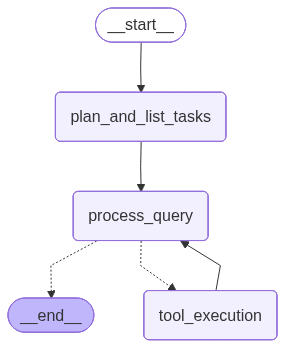

Agent graph visualization created successfully!


In [127]:
from IPython.display import Image, display

# Visualize the agent graph
try:
    display(Image(main_agent.get_graph().draw_mermaid_png()))
    print("Agent graph visualization created successfully!")
except Exception as e:
    print(f"Could not create graph visualization: {e}")

In [128]:
questions = [
    # Uncomment to test different questions
    # "Which genre has the oldest painting?",
    # "How many paintings are there from the Renaissance period?",
    # "What is shown in the painting image with the oldest year?",
    # "Get the century of the newest painting per genre.",
    # "Plot the number of paintings for each year.",
    "Get the number of swords shown in oldest paintings from the Renaissance period.",
]

print("=" * 80)
print("Starting Agent Execution")
print("=" * 80)

for question in questions:
    print(f"\n{'='*80}")
    print(f"Question: {question}")
    print(f"{'='*80}")
    
    try:
        for step in main_agent.stream(
            {"messages": [{"role": "user", "content": question}]},
            stream_mode="values",
        ):
            # Print the last message from the stream
            if "messages" in step and step["messages"]:
                last_message = step["messages"][-1]
                print(f"\n[{type(last_message).__name__}]")
                if hasattr(last_message, 'pretty_print'):
                    last_message.pretty_print()
                else:
                    print(last_message)
    except Exception as e:
        print(f"Error during execution: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print("Agent Execution Completed")
print(f"{'='*80}")

Starting Agent Execution

Question: Get the number of swords shown in oldest paintings from the Renaissance period.

[HumanMessage]
================================ Human Message =================================

Get the number of swords shown in oldest paintings from the Renaissance period.

[HumanMessage]
================================ Human Message =================================

Get the number of swords shown in oldest paintings from the Renaissance period.

Processing step 1/3: Query the database for Renaissance period paintings to find the oldest ones using the database_exploration_agent.
Found 1 tool call(s) to execute

[AIMessage]
================================== Ai Message ==================================
Tool Calls:
  database_exploration_agent (call_Vol5HBhDx4GW5aJuO1CDrnky)
 Call ID: call_Vol5HBhDx4GW5aJuO1CDrnky
  Args:
    query: Find the oldest paintings from the Renaissance period.
Executing tool: database_exploration_agent
Tool database_exploration_agent succ